# Imports

In [4]:
import numpy as np
from recode import decode_pcm_bytes

from functools import partial
from more_itertools import take 
from audiostream2py.file import WavFileSourceReader
from audiostream2py.data import AudioSegment # switch to other branch

def audio_plc_gen(accel_source, plc_source):
    # with accel_source.stream_buffer(maxlen=None) as accel_buffer:
    #     with plc_source.stream_buffer(maxlen=None) as plc_buffer:
            # accel_reader = accel_buffer.mk_reader()
            # plc_reader = plc_buffer.mk_reader()
            # next_audio = partial(accel_reader.next, ignore_no_item_found=True)
            # next_plc = partial(plc_reader.next, ignore_no_item_found=True)
    with accel_source:
        with plc_source:
            while True:
                # audio = next_audio()
                # plc = next_plc()
                audio = accel_source.read()
                plc = plc_source.read()
                yield audio, plc

plc_file = '../data/PLC.wav'
accel_file = '../data/1621346260226336_ch2.wav'

plc_source = WavFileSourceReader(plc_file, frames_per_buffer=50, start_date=0) #frames per buffer was 5 
accel_source = WavFileSourceReader(accel_file, frames_per_buffer=12800, start_date=0)

from audiostream2py.file import file_to_audio_segment
wf_segment = file_to_audio_segment(file=accel_file)



In [2]:
# my_gen = audio_plc_gen(accel_source, plc_source)
# for _ in range(300):
#     audio, plc = next(my_gen)
#     #plc = plc_source.read()
#     #audio = accel_source.read()
#     print(plc, audio)

# Using dags

In [21]:
from creek.automatas import BasicAutomata, mapping_to_transition_func
from typing import Callable, MutableMapping, Any, Mapping, Literal
from dataclasses import dataclass
from i2 import ch_names
from pprint import pprint
import numpy as np
from creek import BufferStats
from statistics import mean
from collections import deque

Case = Any
Cases = Mapping[Case, Callable]


RecordingCommands = Literal["start", "resume", "stop"]

def get_bytes_of_audio_segment(audio_segment: AudioSegment) -> bytes:
    return audio_segment.waveform

def convert_bytes_to_array(bytes_: bytes, dtype: type) -> np.ndarray:
    return np.frombuffer(bytes_, dtype=dtype)

def convert_array_to_bool(array: np.ndarray) -> np.ndarray:
    return array != 0 

def audio_segment_to_int(audio_segment: AudioSegment) -> np.ndarray:
    bytes_ = get_bytes_of_audio_segment(audio_segment)
    array = convert_bytes_to_array(bytes_, dtype=np.int16)
    bool_array = convert_array_to_bool(array)
    int_array = bool_array.astype(np.int8)
    return list(int_array)

def plc_segment_to_bool(plc_segment: AudioSegment) -> np.ndarray:
    return np.array(decode_pcm_bytes(plc_segment.waveform))

def get_audio_ts_from_index(audio_segment: AudioSegment, index: int) -> tuple:
    return audio_segment.get_ts_of_frame_index(index)

def get_bt_of_ts(ts: tuple):
    return ts[0]

edges_ones_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1],
ts_for_edge_one = lambda edges_ones_idx, plc_segment: [get_audio_ts_from_index(plc_segment, i) for i in edges_ones_idx],

@dataclass
class RecordingSwitchBoard:
    store: MutableMapping = None
    _current_key = None

    def start(self, key, chk):
        self._current_key = key
        self.store[key] = []
        self._append(chk)

    def resume(self, key, chk):
        print(f'resume called')
        self._append(chk)

    def stop(self, key, chk):
        self._append(chk)
        self._current_key = None

    def _append(self, chk):
        if self._current_key is None:
            raise ValueError("Cannot append without first starting recording.")
        self.store[self._current_key].extend(chk)

    @property
    def is_recording(self):
        return self._current_key is not None


@dataclass
class SimpleSwitchCase:
    """A functional implementation of thw switch-case control flow.
    Makes a callable that takes two arguments, a case and an input.

    >>> f = SimpleSwitchCase({'plus_one': lambda x: x + 1, 'times_two': lambda x: x * 2})
    >>> f('plus_one', 2)
    3
    >>> f('times_two', 2)
    4
    """

    cases: Mapping[Case, Callable]

    def __call__(self, case, input):
        func = self.cases.get(case, None)
        if func is None:
            raise ValueError(f"Case {case} not found.")
        return func(input)


def mk_simple_switch_case(
    cases: Cases, *, name: str = None, case_name: str = None, input_name: str = None
):
    """
    Makes a simple switch-case function, with optional naming control.
    """
    switch_case_func = SimpleSwitchCase(cases)
    switch_case_func = ch_names(
        switch_case_func, **dict(case=case_name, input=input_name)
    )
    if name is not None:
        switch_case_func.__name__ = name
    return switch_case_func


def mk_recorder_switch(
    store, *, mk_recorder: Callable[[MutableMapping], Any] = RecordingSwitchBoard
):
    recorder = mk_recorder(store)
    return mk_simple_switch_case(
        {
            "start": lambda key_and_chk: recorder.start(*key_and_chk),
            "resume": lambda key_and_chk: recorder.resume(*key_and_chk),
            "stop": lambda key_and_chk: recorder.stop(*key_and_chk),
            "waiting": lambda x: None,
        },
        name="recorder_switch",
        case_name="state",
        input_name="key_and_chk",
    )


def mk_transition_func(
    trans_func_mapping,
    initial_state,  # symbol_var_name: str,
):
    recording_state_transition_func = mapping_to_transition_func(
        trans_func_mapping,
        strict=False,
    )
    transitioner = BasicAutomata(
        transition_func=recording_state_transition_func,
        state=initial_state,
    )

    # @i2.ch_names(symbol=symbol_var_name)
    def transition(symbol):
        return transitioner.transition(symbol)

    # transition = transitioner.reset().transition

    return transition

class AudioSegmentProcessorOld:
    write_state = False
    buffered_segment = [AudioSegment.empty()] # [] is better

    def __call__(self, segment, ts=None):
        if isinstance(ts, list):
            ts = ts[0]
        if (not self.write_state) and ts is None:
            return None
        if (not self.write_state) and ts:
            self.buffered_segment = [segment[ts:]]
            self.write_state = True
        if self.write_state and ts is None:
            self.buffered_segment += [segment]
        if self.write_state and ts:
            result = self.buffered_segment + [segment[:ts]]
            self.buffered_segment = [segment[ts:]]
            return result

def sum_none(a,b):
    if a is None:
        return b
    if b is None:
        return a
    return a + b
    

class AudioSegmentProcessor_addition:
    write_state = False
    buffered_segment = None 

    def __call__(self, segment, ts=None):
        if isinstance(ts, list):
            ts = ts[0]
        if (not self.write_state) and ts is None:
            return None
        elif (not self.write_state) and ts:
            self.buffered_segment = segment[ts:]
            self.write_state = True
        elif self.write_state and ts is None:
            self.buffered_segment = sum_none(self.buffered_segment, segment)
        elif self.write_state and ts:
            result = sum_none(self.buffered_segment ,segment[:ts])
            self.buffered_segment = segment[ts:]
            return result

class AudioSegmentProcessor:
    write_state = False
    buffered_segment = AudioSegment.empty() # use something more general

    def __call__(self, segment, ts=None):
        if isinstance(ts, list):
            ts = ts[0]
        if (not self.write_state) and ts is None:
            return None
        elif (not self.write_state) and ts:
            self.buffered_segment = segment[ts:]
            self.write_state = True
            return None
        elif self.write_state and ts is None:
            self.buffered_segment = AudioSegment.concatenate([self.buffered_segment, segment])
            return None
        elif self.write_state and ts:
            result = AudioSegment.concatenate([self.buffered_segment , segment[:ts]])
            self.buffered_segment = segment[ts:]
            return result




def mk_audio_segment_processor():
    return AudioSegmentProcessor()

def rising(d):
    x,y=d
    return int(x<y)

def mk_event_detector(values=(0,), maxlen=2, func=rising):
    bs = BufferStats(values = values,maxlen=maxlen, func=func) 
    def detector(segment):
        return [bs(item) for item in segment]
    return detector

def append_if_not_none(l, item):
    if not item is None:
        l.append(item)

    return l


def mk_buffer(values =(0.,),maxlen=5, func=mean, add_new_val=deque.append):
    bs = BufferStats(values=values,maxlen=maxlen, func=func, add_new_val=add_new_val) 
    return bs

def flatten(l):
    res = []
    for item in l:
        if isinstance(item, list):
            res.extend(item)
        else:
            res.append(item)
    return res

def plot_rising_edges(wf_segment, ts_list):
    import matplotlib.pyplot as plt

    frames = [wf_segment._nearest_frame_index(ts) for ts in ts_list if ts]

    x_max = max(frames)
    _, ax = plt.subplots(1,1, figsize=(20,10))
    ax.plot(convert_bytes_to_array(wf_segment.waveform, dtype=np.int16)[:x_max])
    for frame in frames:
        ax.axvline(x=frame,color='r')
    plt.show()

# trans_func_mapping = {
#     ("waiting", 1): "start",
#     ("start", 0): "resume",
#     ("start", 1): "stop",
#     ("resume", 1): "stop",
#     ("stop", 0): "waiting",
#     ("stop", 1): "start",
# }

# trans_func_mapping = {
#     ("w", 1): "n",
#     ("n", 0): "c",
#     #("n", 1): "c",
#     ("c", 1): "n",
#     #("c", 0): "w",
#     #("stop", 0): "start",
#     #("stop", 1): "start",
# }
trans_func_mapping = {
    (0, 1): 1,
    (1, 1): 0,
    (1, 0): 0,
    (0, 0): 0,
    #("c", 0): "w",
    #("stop", 0): "start",
    #("stop", 1): "start",
}
plc_symbols = ['00', '01', '10', '11'] # ['a', 'b', 'c', 'd']

In [22]:
wf_segment

AudioSegment(start_date=0, end_date=1193000000.0, frame_count=15270400, status_flags=0)

In [23]:
# a= AudioSegment.empty()
# b= AudioSegment.empty()
#sum([wf_segment, wf_segment])
#__radd__


class S:
    def __init__(self, value):
        self.value = value

    def __add__(self, other):
        return S(self.value + other.value)
    
    def __radd__(self, other):
        if other == 0:
            return self
# 
    def __repr__(self) -> str:
        return f"{self.value}"

In [24]:
#  '0+object' means object.__radd__(0)

In [25]:
sum([S(1), S(2), S(3)])

6

In [26]:
isinstance(12, int)

True

In [27]:
# 'AudioSegment'
#-->Self

#from typing import Self # only in python 3.11
#https://peps.python.org/pep-0673/
from typing import TypeVar

TAudioSegment = TypeVar("TAudioSegment", bound="AudioSegment")


In [28]:
# pymonad

## Using sums instead of concatenate

In [29]:
# without modification, needs to use a start parameter
#sum([debug_arr[0], debug_arr[1]], start = AudioSegment.empty())

# with modification, needs to redefine __radd__

In [33]:
from meshed import DAG

# object storing state information
#store = dict()
event_detector = mk_event_detector()
ap = mk_audio_segment_processor()
buffer_5 = mk_buffer(maxlen=5, func=mean, add_new_val = append_if_not_none)

# debug timestamps
debug_ts = []

# definition of the dag
dag = DAG.from_funcs(
    int_segment = lambda plc_segment: audio_segment_to_int(plc_segment),
    edges = lambda int_segment: event_detector(int_segment), #segment of same size, with edges indicated
    edges_ones_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1], #indices of edges occuring
    ts_for_edge_one = lambda edges_ones_idx, plc_segment: [get_bt_of_ts(get_audio_ts_from_index(plc_segment, i)) for i in edges_ones_idx] or None,
    ts_debug = lambda ts_for_edge_one: debug_ts.append(ts_for_edge_one),
    audio_segment = lambda audio, ts_for_edge_one: ap(audio, ts_for_edge_one),
    audio_waveform = lambda audio_segment: convert_bytes_to_array(audio_segment.waveform, dtype=np.int16) if audio_segment else None,
    std_audio_segment = lambda audio_waveform: np.std(audio_waveform) if (not audio_waveform is None) else None,
    buffer_5 = lambda std_audio_segment: buffer_5(std_audio_segment), #outputting the mean
)

In [34]:

def horizontal_plot(dag):
    from graphviz.graphs import Digraph
    from meshed.dag import _add_new_line_if_none

    body = list(map(_add_new_line_if_none, dag.dot_digraph_body()))
    return Digraph(body=body,  graph_attr={'rankdir':'LR'}
    )


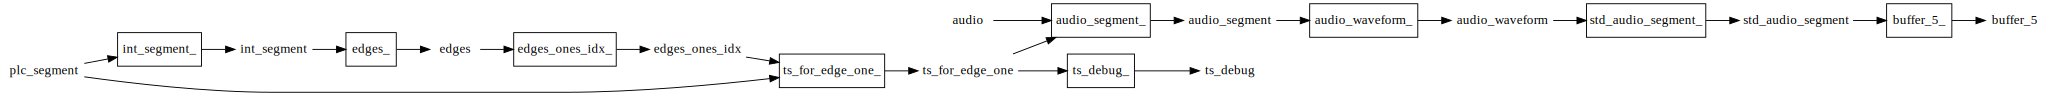

In [42]:
# start_lines means actually a preamble!
dag.dot_digraph(start_lines='rankdir=LR')

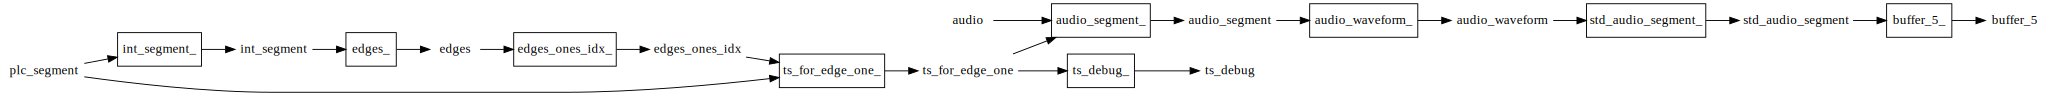

In [35]:
horizontal_plot(dag)

In [36]:
# run the dag
DFLT_NUM_SEGMENTS = 100
plc_source = WavFileSourceReader(plc_file, frames_per_buffer=50, start_date=0)
accel_source = WavFileSourceReader(accel_file, frames_per_buffer=12800, start_date=0)
my_gen = audio_plc_gen(accel_source, plc_source)

for _ in range(DFLT_NUM_SEGMENTS):
    audio, plc = next(my_gen)
    result = dag(plc_segment=plc , audio =audio)
    print(f' -------> released_std={result}')
    

 -------> released_std=(None, 0.0)
 -------> released_std=(None, 0.0)
 -------> released_std=(None, 0.0)
 -------> released_std=(None, 0.0)
 -------> released_std=(None, 507.76449944042366)
 -------> released_std=(None, 507.76449944042366)
 -------> released_std=(None, 507.76449944042366)
 -------> released_std=(None, 729.381980160787)
 -------> released_std=(None, 729.381980160787)
 -------> released_std=(None, 729.381980160787)
 -------> released_std=(None, 896.9350282608593)
 -------> released_std=(None, 896.9350282608593)
 -------> released_std=(None, 896.9350282608593)
 -------> released_std=(None, 928.0040403114583)
 -------> released_std=(None, 928.0040403114583)
 -------> released_std=(None, 928.0040403114583)
 -------> released_std=(None, 1072.8090312867366)
 -------> released_std=(None, 1072.8090312867366)
 -------> released_std=(None, 1072.8090312867366)
 -------> released_std=(None, 1114.4913014879323)
 -------> released_std=(None, 1114.4913014879323)
 -------> released_std

In [ ]:
# the classifier for stamping press:
# log_normal distribution
estimate the mu, sigma
# then compute the value
# compare with a threshold

# or use Stroll with one centroid only may be,
# make dag template or a class for that

In [37]:
debug_ts=flatten(debug_ts)
debug_ts

[None,
 1180000.0,
 None,
 None,
 4160000.0,
 None,
 None,
 7140000.0,
 None,
 None,
 10120000.0,
 None,
 None,
 13100000.0,
 None,
 None,
 16080000.0,
 None,
 None,
 19060000.0,
 None,
 None,
 22020000.0,
 None,
 None,
 25020000.0,
 None,
 None,
 28000000.0,
 None,
 30980000.0,
 None,
 None,
 33960000.0,
 None,
 None,
 36940000.0,
 None,
 None,
 39920000.0,
 None,
 None,
 42900000.0,
 None,
 None,
 45880000.0,
 None,
 None,
 48860000.0,
 None,
 None,
 51840000.0,
 None,
 None,
 54820000.0,
 None,
 None,
 57800000.0,
 None,
 None,
 60780000.0,
 None,
 None,
 63760000.0,
 None,
 None,
 66740000.0,
 None,
 None,
 69720000.0,
 None,
 None,
 72700000.0,
 None,
 None,
 75680000.0,
 None,
 None,
 78660000.0,
 None,
 None,
 81640000.0,
 None,
 None,
 84620000.0,
 None,
 None,
 87600000.0,
 None,
 None,
 90580000.0,
 None,
 None,
 93560000.0,
 None,
 None,
 96540000.0,
 None,
 None,
 99520000.0]

# Visualizing the results

In [38]:
from audiostream2py.file import file_to_audio_segment
wf_segment = file_to_audio_segment(file=accel_file)

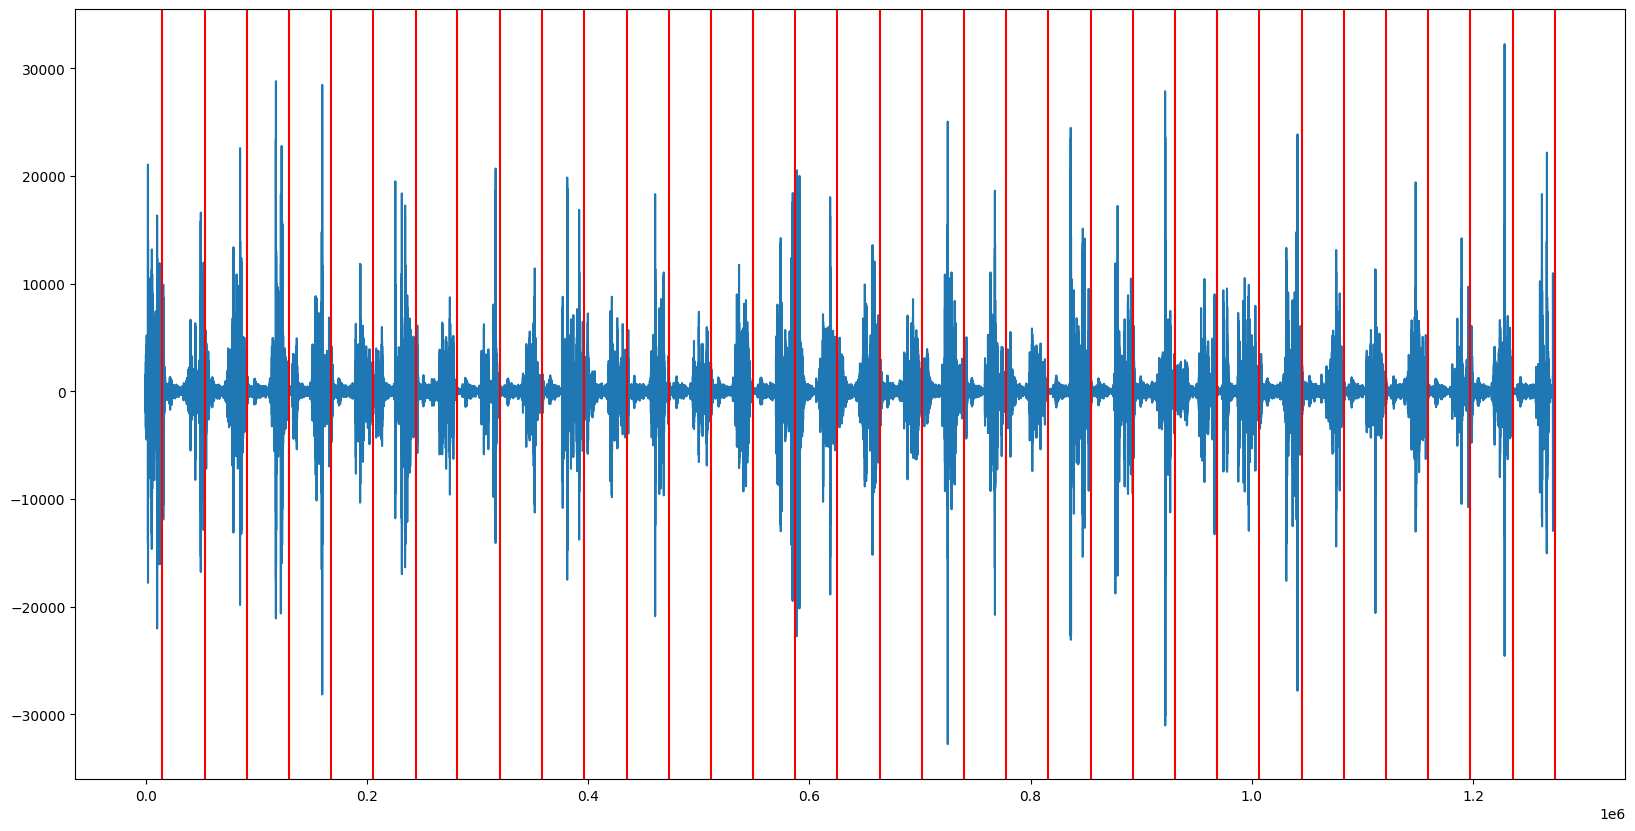

In [39]:
plot_rising_edges(wf_segment, debug_ts)